In [30]:
import numpy as np
import pandas as pd
import os
import matplotlib . pyplot as plt
from matplotlib.widgets import Slider
import graphviz
from graphviz import Digraph

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , mean_squared_error, accuracy_score

from sklearn.datasets import make_classification

### Build DecisionTree Node

In [58]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, mse =None):
        """
        feature: significant index to split branch
        threshold: threshold to device branch
        left: left branch of Tree
        right: right branch of Tree
        value: value 
        
        """
        self.feature = feature      
        self.threshold = threshold  
        self.left = left    
        self.right = right  
        self.value = value  
        self.mse = mse

### Build Decision Tree Regressor

In [61]:
class DecisionTreeRegressorCus:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y))
        self.root = self._grow_tree(X, y, sample_weight, depth=0)

    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def _grow_tree(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        mse = np.average((y - np.average(y, weights=sample_weight)) ** 2, weights=sample_weight)

        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split:
            return DecisionTreeNode(value=np.average(y, weights=sample_weight), mse=mse)

        best_feature, best_threshold = self._best_split(X, y, sample_weight, n_features)
        if best_feature is None:
            return DecisionTreeNode(value=np.average(y, weights=sample_weight), mse=mse)

        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        left = self._grow_tree(X[left_indices], y[left_indices], sample_weight[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], sample_weight[right_indices], depth + 1)

        total_mse = left.mse + right.mse

        return DecisionTreeNode(
            feature=best_feature, 
            threshold=best_threshold, 
            left=left, 
            right=right, 
            mse=total_mse
        )

    def _best_split(self, X, y, sample_weight, n_features):
        best_mse = float('inf')
        best_feature, best_threshold = None, None
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                mse = self._calculate_weighted_mse(X[:, feature], y, sample_weight, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _calculate_weighted_mse(self, feature_column, y, sample_weight, threshold):
        left_indices = feature_column < threshold
        right_indices = feature_column >= threshold
        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            return float('inf')
        y_left, y_right = y[left_indices], y[right_indices]
        weight_left, weight_right = sample_weight[left_indices], sample_weight[right_indices] 
        
        mse_left = np.average((y_left - np.average(y_left, weights=weight_left)) ** 2, weights=weight_left)
        mse_right = np.average((y_right - np.average(y_right, weights=weight_right)) ** 2, weights=weight_right)
        
        mse = (np.sum(weight_left) * mse_left + np.sum(weight_right) * mse_right) / np.sum(sample_weight)
        
        return mse

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature] < node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)


### Data Preparing

mse: 0.10809357318253665


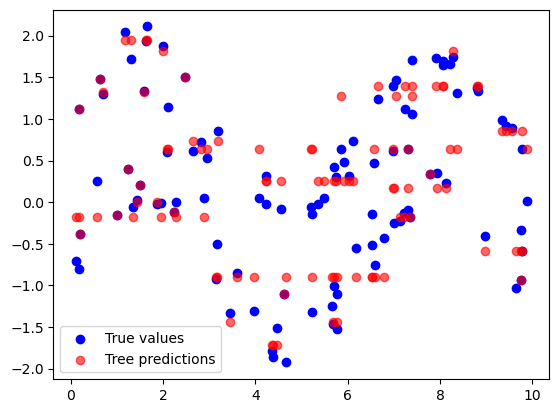

In [70]:
np.random.seed(0)
X = np.random.rand(100, 2) * 10  
y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.random.normal(0, 0.1, 100)

sample_weights = np.ones(len(y))  # all weights = 1

tree = DecisionTreeRegressorCus(max_depth=5)
tree.fit(X, y, sample_weight=sample_weights)

y_pred = tree.predict(X)

print(f'mse: {mean_squared_error(y, y_pred)}')
plt.scatter(X[:, 0], y, color = 'blue',label='True values')
plt.scatter(X[:, 0], y_pred, color='red', label='Tree predictions', alpha=0.6)
plt.legend()
plt.show()

### Save Tree

In [67]:
def visualize_tree(node, depth=0, graph=None, node_counter=[0]):
    if graph is None:
        graph = Digraph()

    current_node = node_counter[0]
    node_counter[0] += 1

    if node.value is not None:
        graph.node(f'node{current_node}', 
                   f'Value: {node.value:.5f}\nMSE: {node.mse:.5f}')
    else:
        graph.node(f'node{current_node}',
                   f'Feature: {node.feature}, Threshold: {node.threshold:.5f}\nTotal MSE: {node.mse:.5f}')

    if node.left:
        left_node = node_counter[0]
        graph.edge(f'node{current_node}', f'node{left_node}', label="True")
        visualize_tree(node.left, depth + 1, graph, node_counter)

    if node.right:
        right_node = node_counter[0]
        graph.edge(f'node{current_node}', f'node{right_node}', label="False")
        visualize_tree(node.right, depth + 1, graph, node_counter)

    return graph

np.random.seed(0)
X = np.random.rand(100, 2) * 10  # 100 mẫu, mỗi mẫu có 2 features
y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.random.normal(0, 0.1, 100)

tree = DecisionTreeRegressorCus(max_depth=3)
tree.fit(X, y)

#### Dot configuration

In [64]:
dot_path = '/opt/homebrew/bin/dot'
print(f'os path: {os.pathsep + os.path.dirname(dot_path)}')
os.environ["PATH"] += os.pathsep + os.path.dirname(dot_path)

os path: :/opt/homebrew/bin


#### Add PATH dot and save structure of DecisionTree

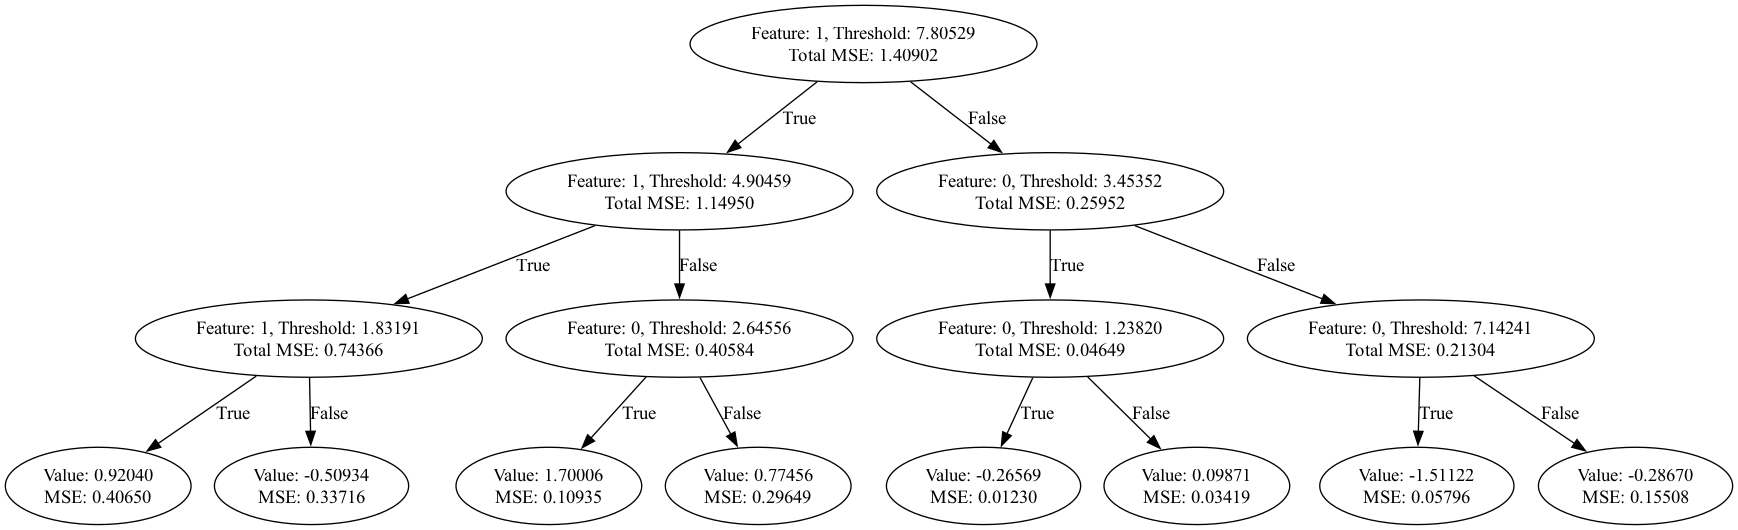

In [68]:
tree_graph = visualize_tree(tree.root)

tree_graph.render('decision_tree', format='png', cleanup=True)

from IPython.display import Image
Image(filename='decision_tree.png')

### Test with data 1D Customize

[[5.48813504 7.15189366]
 [6.02763376 5.44883183]
 [4.23654799 6.45894113]]
[ 0.04457804  0.31088458 -0.01905999]


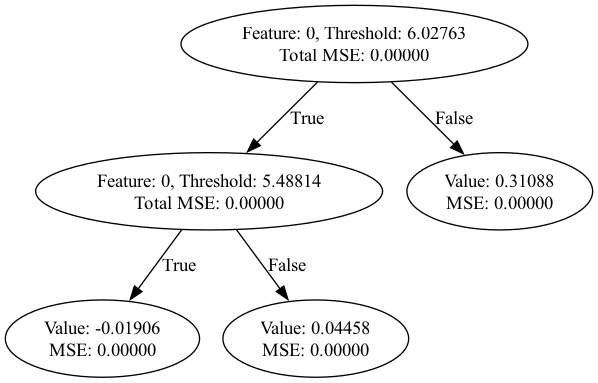

In [82]:
X_new = X [0:3]
y_new = y [0:3]

print(X_new)
print(y_new)

tree = DecisionTreeRegressorCus(max_depth=2)
tree.fit(X_new, y_new,sample_weight= np.ones(3))

tree_graph = visualize_tree(tree.root)  

tree_graph.render('decision_tree', format='png', cleanup=True)

from IPython.display import Image
Image(filename='decision_tree.png')

In [55]:
a = np.array([0.04, -0.019])
print(f'mean: {a.mean()}')

print(f'mse: {np.sum((a-a.mean())**2)}')

mean: 0.0105
mse: 0.0017404999999999999


### Test Decision Tree with Housing Data

(545, 12)
(545,)


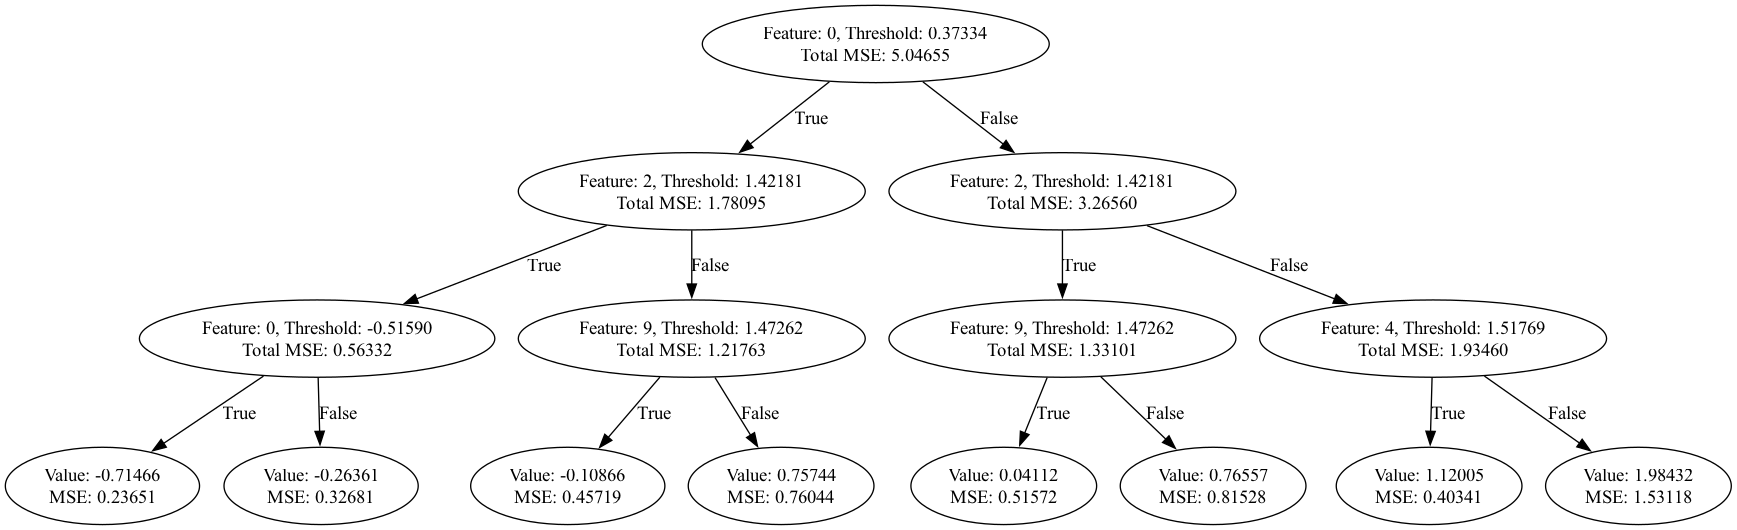

In [76]:
X_new = np.load("housing_data_X.npy")
y_new = np.load("housing_data_y.npy")

print(X_new.shape)
print(y_new.shape)

tree = DecisionTreeRegressorCus(max_depth=3, min_samples_split=2)
tree.fit(X_new, y_new)

tree_graph = visualize_tree(tree.root)
tree_graph.render('decision_tree', format='png', cleanup=True)

from IPython.display import Image
Image(filename='decision_tree.png')